# Problem Statement:



To understand the driving factors behind loan default for portfolio and risk assessment.

In [127]:
# Load Libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [128]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('E:/code/upGrad/LendingClubCaseStudy/loan/loan.csv')
print("\nInformation about the DataFrame:")
print(df.info())


Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB
None


# Clean the Data
- Check for columns which has more than 90% NaN and drop them
- Check for columns which has missing values, analyse if you want to fix/replace data or drop it
- Before updating missing values, format data to make it uniform and of relevant data type
- Update missing data with respective values
- Check columns for invalid data and fix them. For ex: earliest_cr_line can not have future date or ratio open_acc/total_acc can not be creater then one
- Plot Histogram, analyse, identify outliers(>99%) and replace them with median in columns

In [129]:
# Calculate percentage of NaN values in each column
nan_percentage = (df.isna().mean() * 100)
# Filter out columns where the percentage is greater than 90%
columns_to_drop = nan_percentage[nan_percentage >= 90].index
# Drop the columns
df = df.drop(columns=columns_to_drop)

In [130]:
# Check for missing values
isnull_percentage = (df.isnull().mean() * 100)
# Define columns to keep
columns_to_keep = ['emp_length', 'mths_since_last_delinq', 'revol_util', 'pub_rec_bankruptcies', 'last_pymnt_d']
# Filter out columns where the percentage is 100% and not in columns_to_keep
columns_to_drop = isnull_percentage[(isnull_percentage != 0) & (~isnull_percentage.index.isin(columns_to_keep))].index
# Drop the columns
df = df.drop(columns=columns_to_drop)

In [131]:
# Fix data type before so that we can update missing values
df['emp_length'] = df['emp_length'].str.extract('(\d+)')
df['revol_util'] = df['revol_util'].str.rstrip('%').astype(float)
# Convert 'last_pymnt_d' to datetime format
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%d') 


In [132]:
# Update missing values
df['emp_length'] = df['emp_length'].fillna(df['revol_util'].mean())
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())
most_common_date = df['last_pymnt_d'].value_counts().idxmax()
df['last_pymnt_d'] = df['last_pymnt_d'].fillna(most_common_date)


In [133]:
# Club two column details 
df['open_to_total_acc_ratio'] = df['open_acc'] / df['total_acc']
# Find the most occurring value in the open_to_total_acc_ratio column
mode_value = df['open_to_total_acc_ratio'].mode()[0]
# Replace invalid ratios (greater than one) with the mode value
df.loc[df['open_to_total_acc_ratio'] > 1, 'open_to_total_acc_ratio'] = mode_value


In [134]:
# re-evaluate current columns and remove unwanted columns
df.columns
columns_to_drop = ['id', 'member_id', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'issue_d',
       'pymnt_plan', 'url', 'purpose', 'zip_code', 'addr_state', 'total_acc', 
       'initial_list_status', 'out_prncp', 'open_acc', 
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'last_pymnt_amnt',
       'policy_code', 'application_type', 'acc_now_delinq', 'delinq_amnt']
# Drop the columns
df = df.drop(columns=columns_to_drop) 


In [135]:
# Check for missing values
# Fill NaN values with zero
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(0)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)
isnull_percentage = (df.isnull().mean() * 100)

In [136]:
# Convert 'earliest_cr_line' to datetime format,calculate number of months and handle invalid values
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y', errors='coerce')
# Find the most recurring date
most_common_date = df['earliest_cr_line'].mode()[0]
# Calculate the number of months from today
df['earliest_cr_line'] = (datetime.now() - df['earliest_cr_line']).dt.days // 30
# Identify negative values and replace them with NaN
df.loc[df['earliest_cr_line'] < 0, 'earliest_cr_line'] = pd.NaT
# Replace NaN with the most recurring date
df['earliest_cr_line'].fillna((datetime.now() - most_common_date).days // 30, inplace=True)

In [137]:
# Convert values to lowercase to make text uniform
df['verification_status'] = df['verification_status'].str.lower()
df['loan_status'] = df['loan_status'].str.lower()
df['home_ownership'] = df['home_ownership'].str.lower()

# Check for unique values in string columns and 
print(f"Unique values in verification_status: {sorted(df['verification_status'].unique())}")
print(f"Unique values in loan_status: {sorted(df['loan_status'].unique())}")
print(f"Unique values in home_ownership: {sorted(df['home_ownership'].unique())}")

# Values in df['verification_status'] = ['not verified', 'source verified', 'verified']
# replacing  'source verified' as 'verified' as both mean same
df['verification_status'].replace('source verified', 'verified', inplace=True)
print(f"Unique values in verification_status post update: {sorted(df['verification_status'].unique())}")

Unique values in verification_status: ['not verified', 'source verified', 'verified']
Unique values in loan_status: ['charged off', 'current', 'fully paid']
Unique values in home_ownership: ['mortgage', 'none', 'other', 'own', 'rent']
Unique values in verification_status post update: ['not verified', 'verified']


Non-numeric columns: Index(['home_ownership', 'verification_status', 'loan_status', 'last_pymnt_d'], dtype='object')


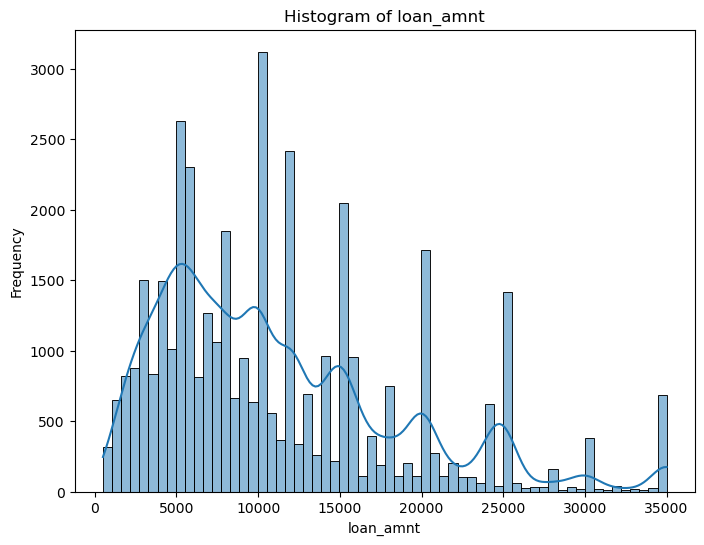

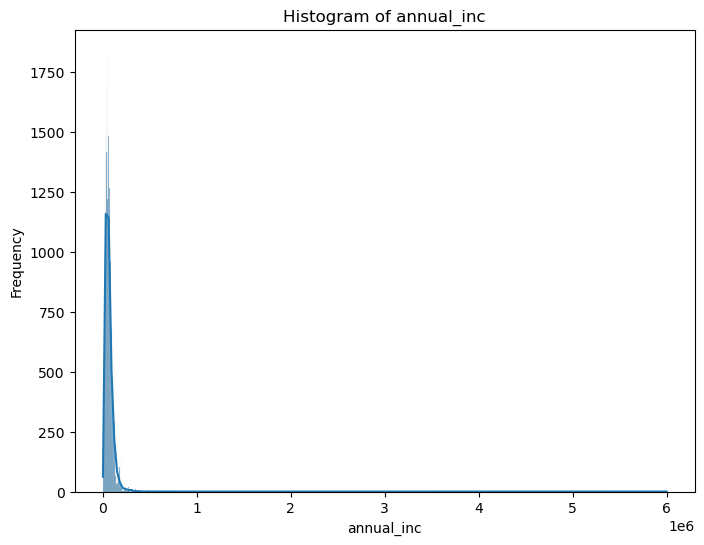

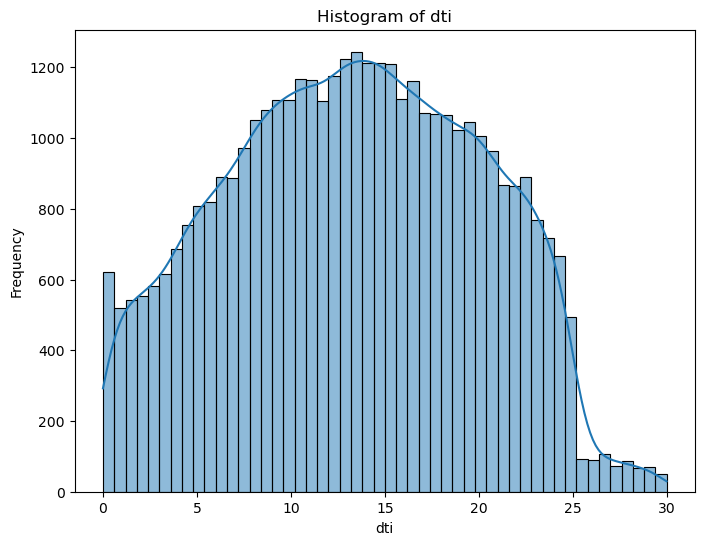

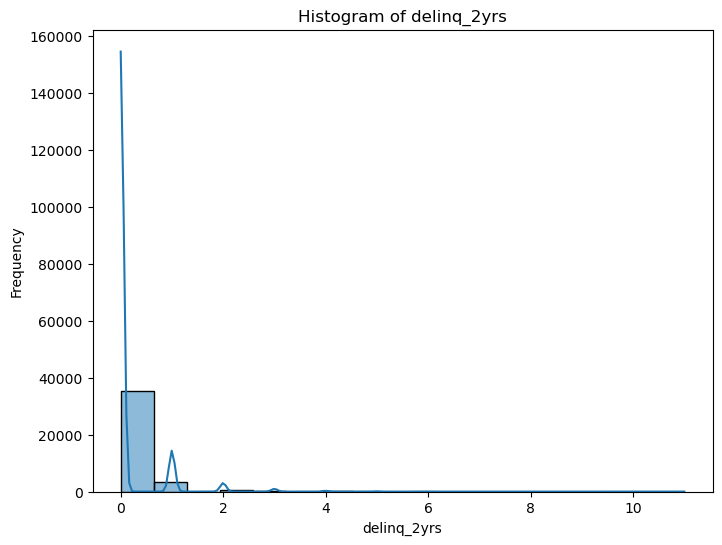

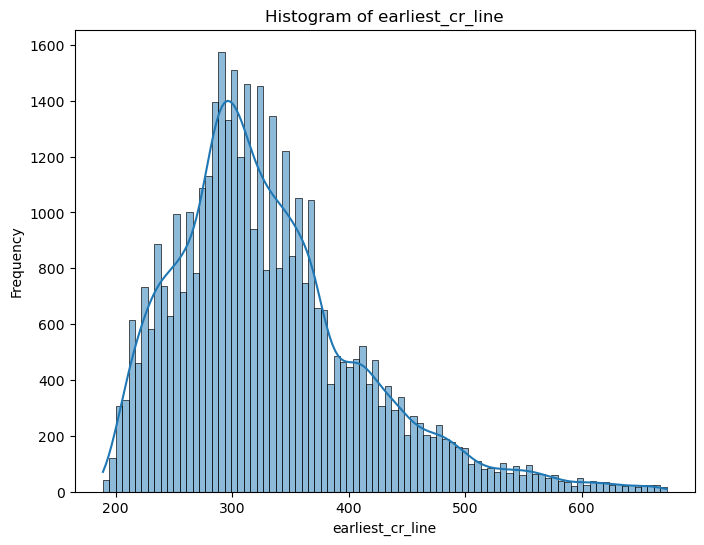

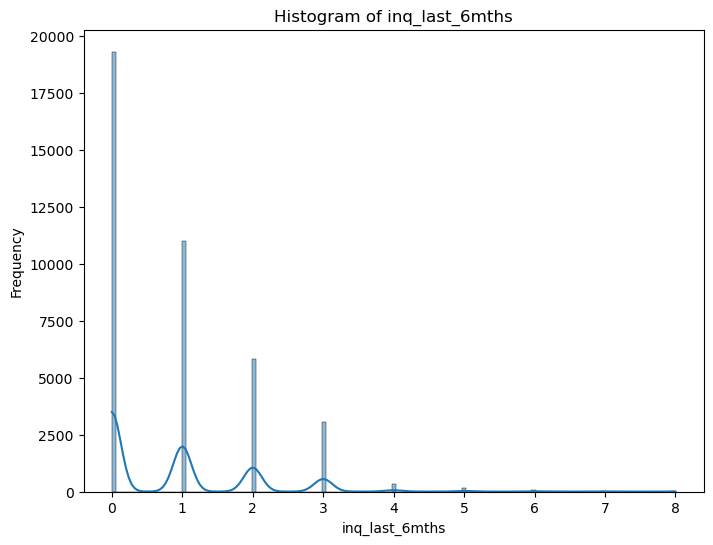

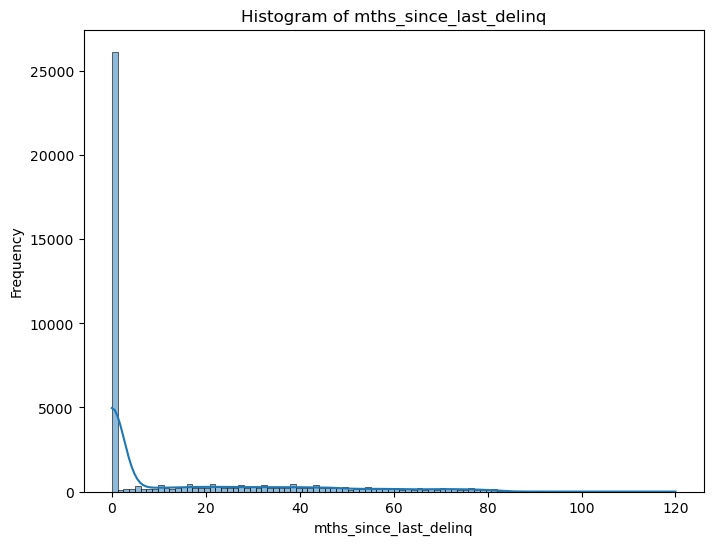

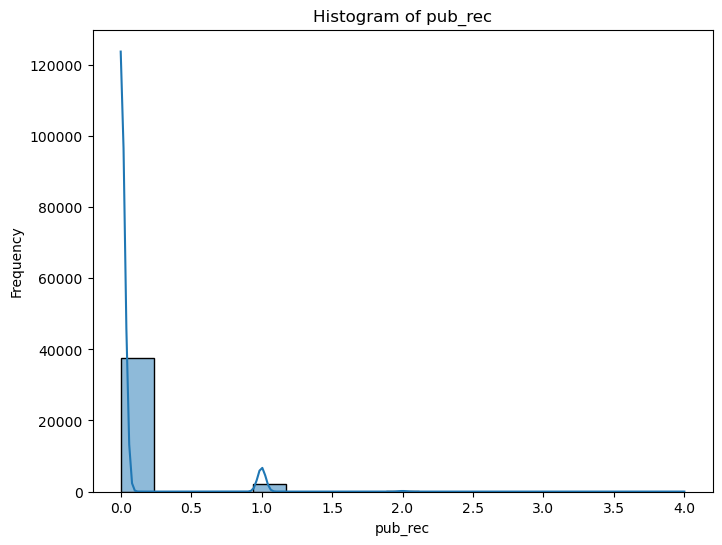

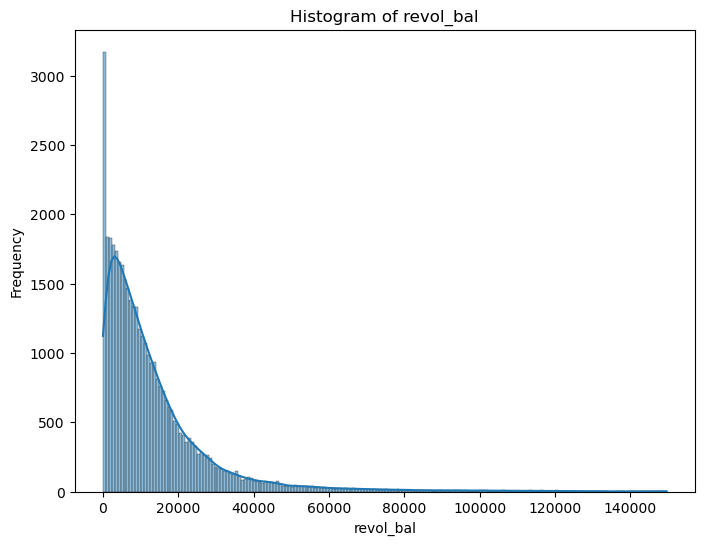

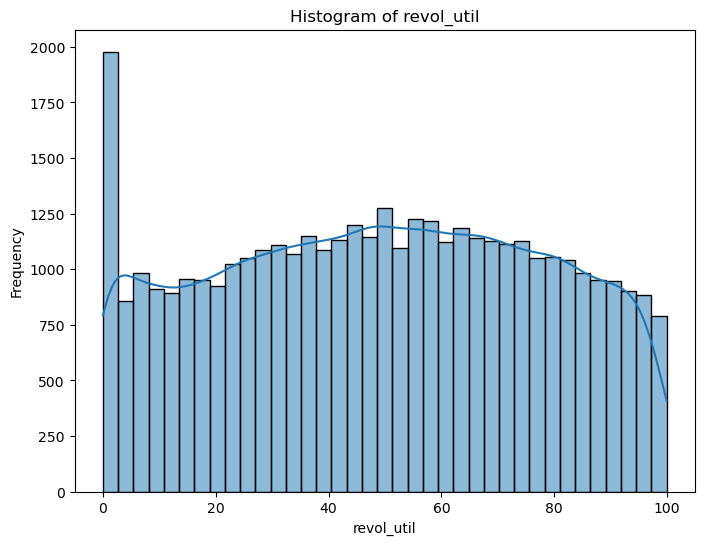

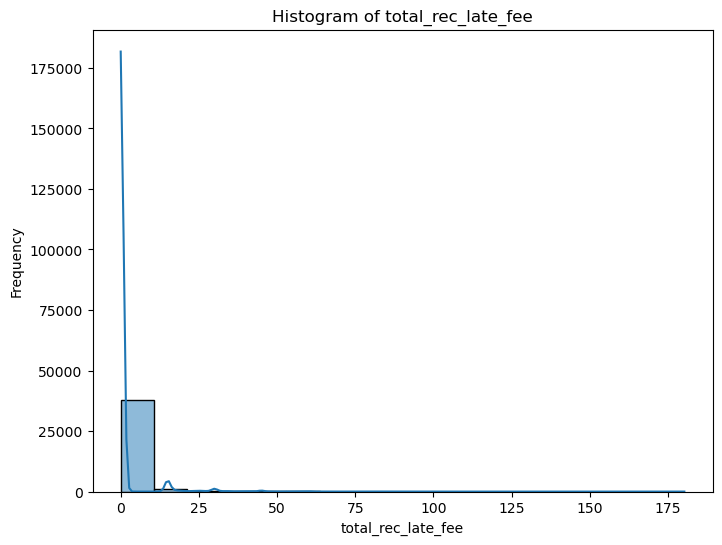

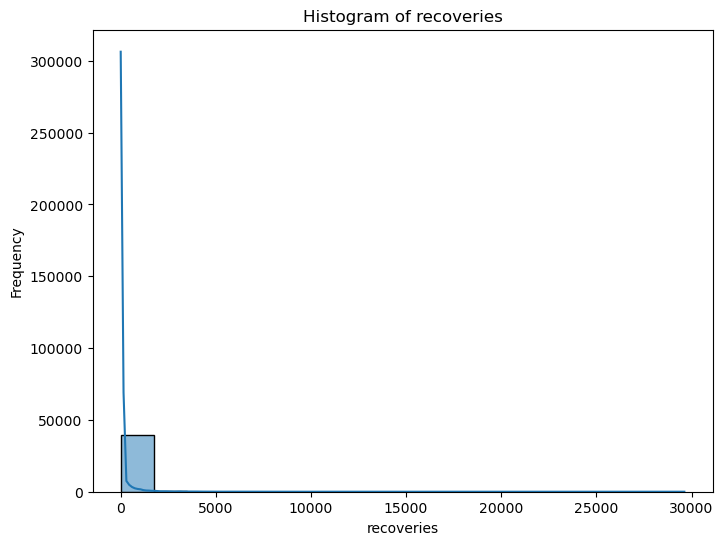

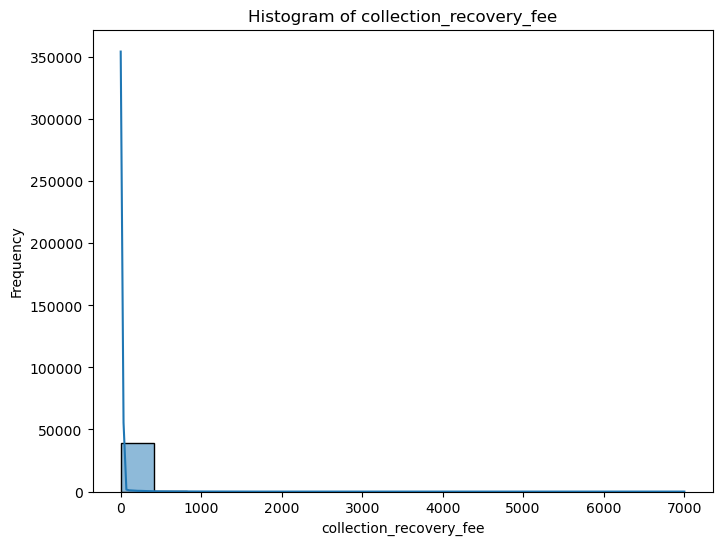

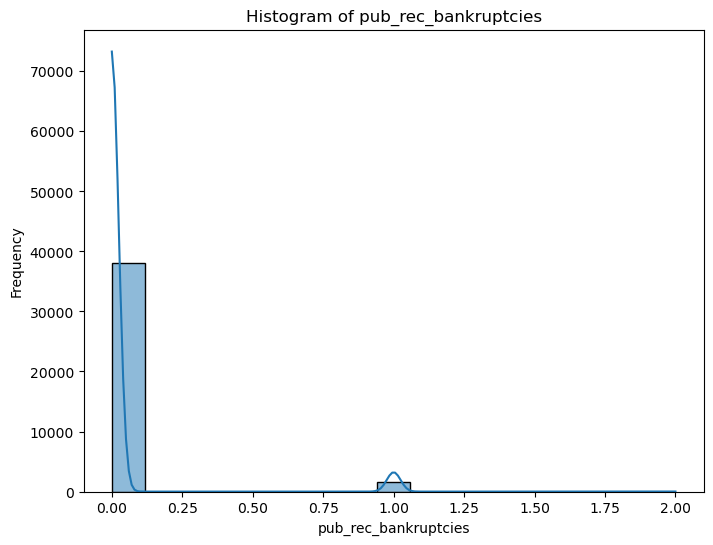

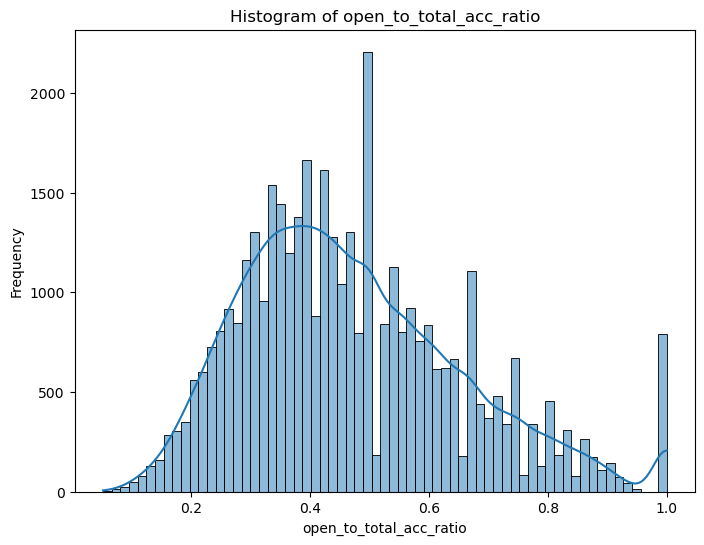

In [138]:
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['float64', 'int64']).columns
# Print non-numeric columns
print("Non-numeric columns:", non_numeric_columns)
# Drop non-numeric columns
numeric_df = df.drop(columns=non_numeric_columns)

# Check for Outliers looking at plots and descrition
for var in numeric_df:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[var], kde=True)
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

In [139]:
# Fix Outliers observed
columns_to_fix_outliers = ['annual_inc', 'mths_since_last_delinq', 
                           'collection_recovery_fee', 'recoveries', 'total_rec_late_fee', 'revol_bal']
# Replace outliers by median
for var in columns_to_fix_outliers:
    median_value = df[var].median()
    upper_bound = df[var].quantile(0.99)
    df.loc[df[var] > upper_bound, var] = median_value

# Univariate Analysis
- Loan Amount : Most Borrowers have applied loan for amount 10000, followed by 5000.
- Annual Income : Most Borrowers have self proclaimed income of 59000.
- 2year Delinquency : Most of the Borrowers have defaulted before finishing 1st year of loan, which is bad.
- Earliest Credit-Line : Most of Borrowers has Credit-Line opened for more than 310months, which is good.
- Verification Status : Most Borrowers had income verfied, which is good. 
- Loan Status : Most Borrowers have fully paid their loan.


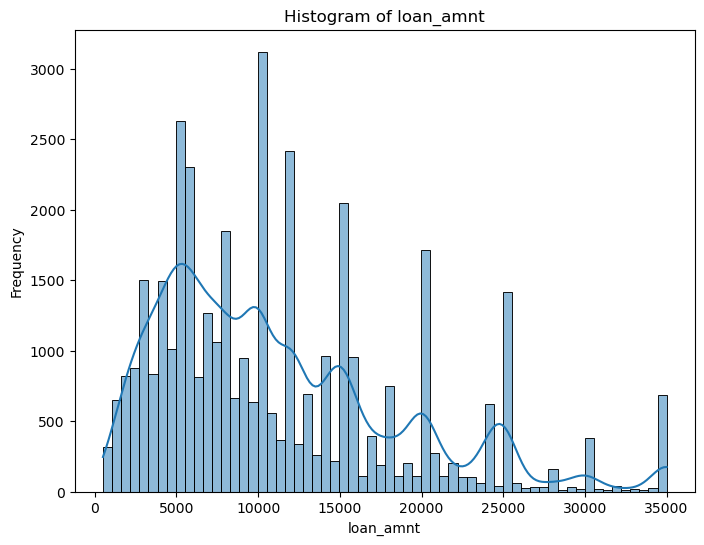

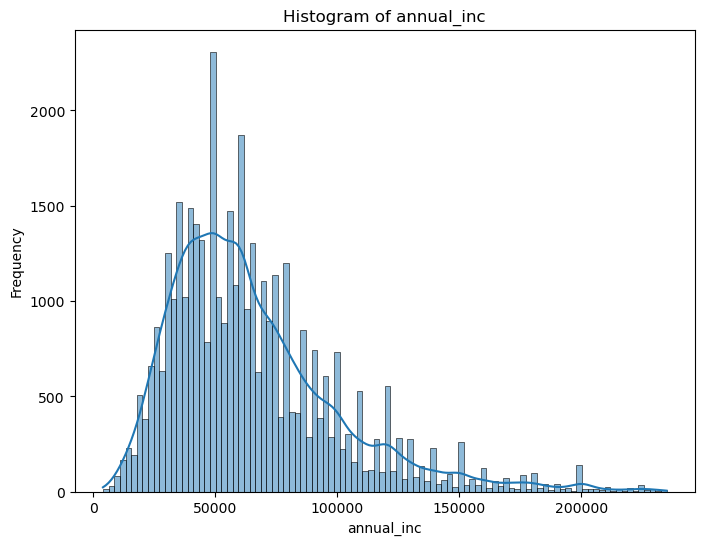

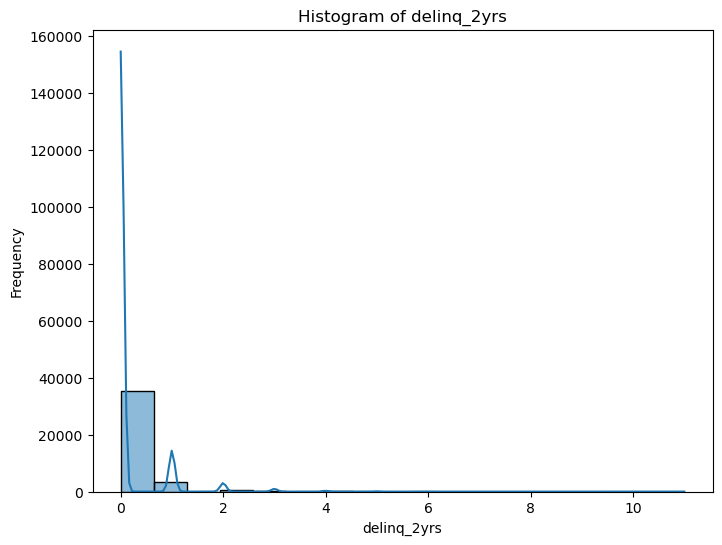

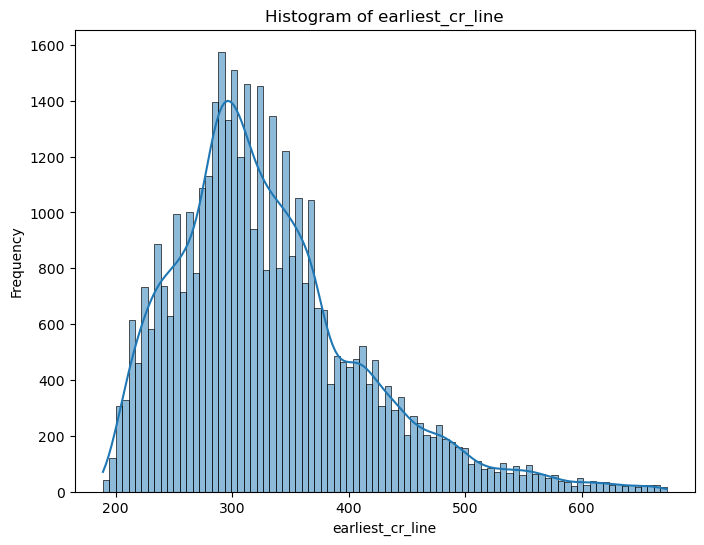

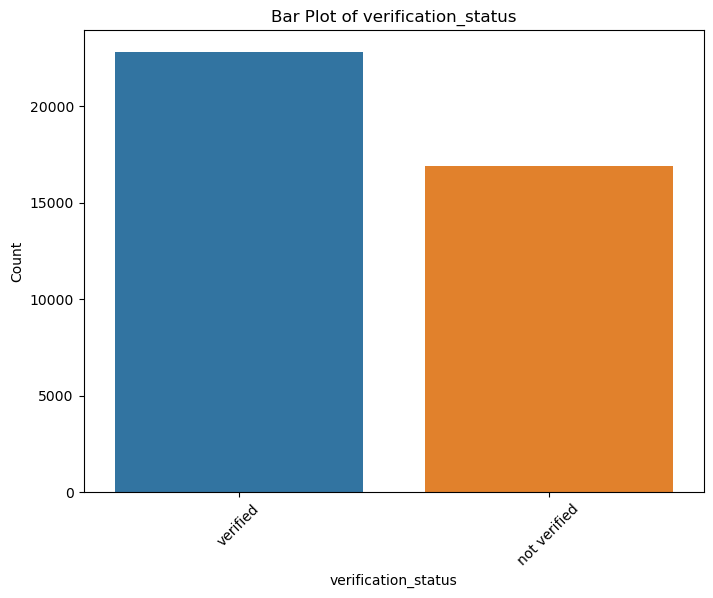

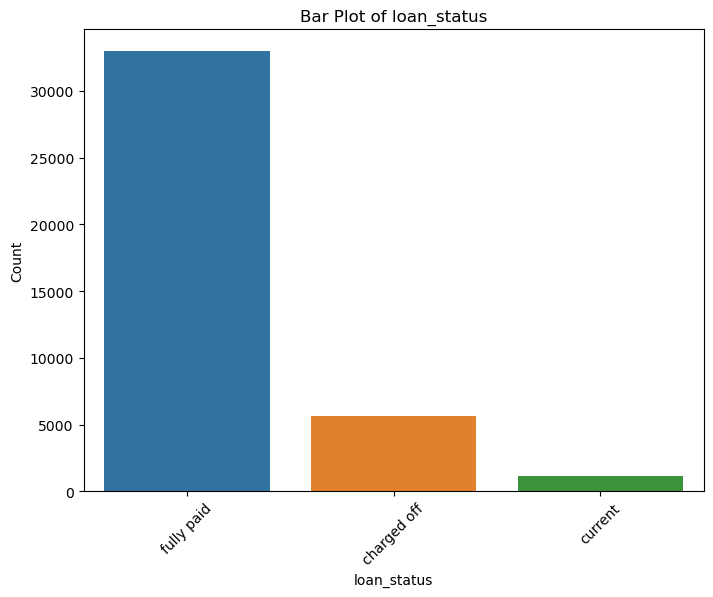

In [140]:


# Plot histograms for continuous variables
continuous_vars = ['loan_amnt', 'annual_inc', 'delinq_2yrs', 'earliest_cr_line']
for var in continuous_vars:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[var], kde=True)
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

# Plot bar plots for categorical variables
categorical_vars = ['verification_status', 'loan_status']
for var in categorical_vars:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=var, data=df)
    plt.title(f'Bar Plot of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


# Bivariate Analysis
- Loan Amount vs. Annual Income:
    - As Income increases from 0 to 50000, Loan Amount gratually increases
    - As Income crosses 100000, number of Loans taken decreases
    - Most Borrower have taken loan with Annual Income less than 100000 and Loan Amount less than 20000.
- Verification Status vs. Loan Status:
    - Full Paid Loans are more when Income was Verified as compare to Not-Verified.
- Loan Status vs. Debt-to-Income Ratio:
    - When DTI ratio is lower for Fully Paid Loans
- Earliest Credit Line vs. Loan Amount:
    - Ealiest Cresit Line is directly proportional to Loan Amount.
- Home Ownership vs. Loan Status:
    - Borrower with Home Ownership as Rent or Own has mostly Paid the Loans fully.

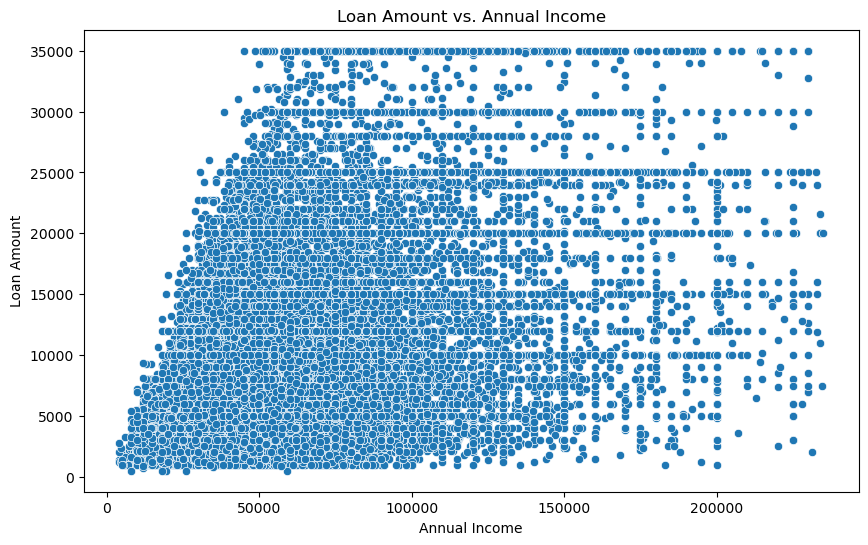

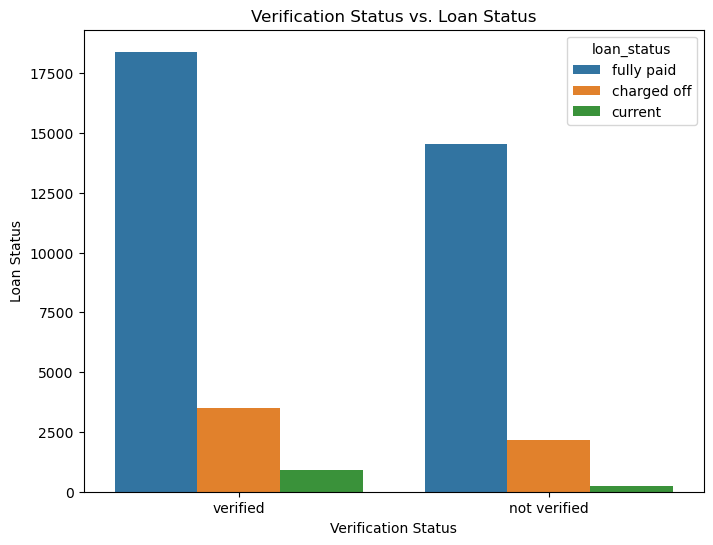

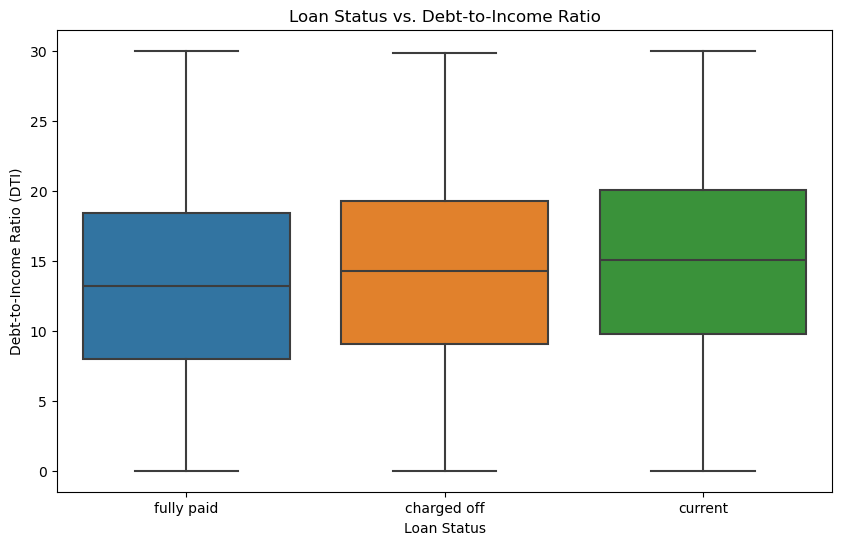

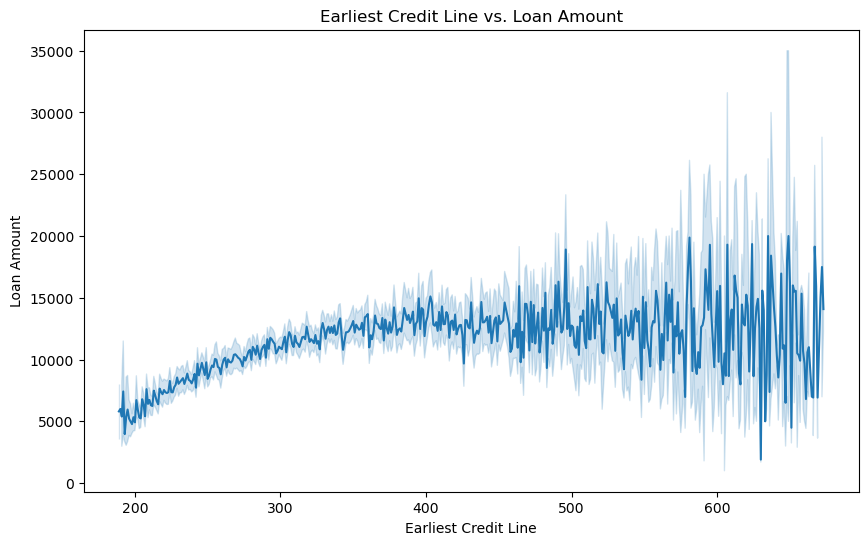

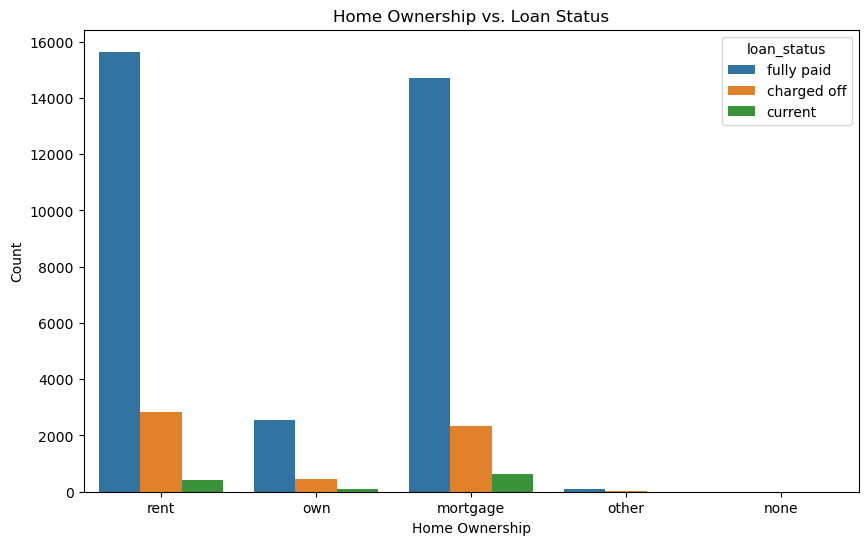

In [141]:
# Loan Amount vs. Annual Income
plt.figure(figsize=(10, 6))
sns.scatterplot(x='annual_inc', y='loan_amnt', data=df)
plt.title('Loan Amount vs. Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.show()

# Verification Status vs. Loan Status
plt.figure(figsize=(8, 6))
sns.countplot(x='verification_status', hue='loan_status', data=df)
plt.title('Verification Status vs. Loan Status')
plt.xlabel('Verification Status')
plt.ylabel('Loan Status')
plt.show()

# Loan Status vs. Debt-to-Income Ratio
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='dti', data=df)
plt.title('Loan Status vs. Debt-to-Income Ratio')
plt.xlabel('Loan Status')
plt.ylabel('Debt-to-Income Ratio (DTI)')
plt.show()

# Earliest Credit Line vs. Loan Amount
plt.figure(figsize=(10, 6))
sns.lineplot(x='earliest_cr_line', y='loan_amnt', data=df)
plt.title('Earliest Credit Line vs. Loan Amount')
plt.xlabel('Earliest Credit Line')
plt.ylabel('Loan Amount')
plt.show()

# Home Ownership vs. Loan Status
plt.figure(figsize=(10, 6))
sns.countplot(x='home_ownership', hue='loan_status', data=df)
plt.title('Home Ownership vs. Loan Status')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.show()


# Multi-variate Analysis
- Loan Amount, Annual Income, and Loan Status
    - Most Borrower have taken loan with Annual Income less than 100000 and Loan Amount less than 20000.
    - Most of the loans are fully paid
    - When Income is between 50,000 to 100,000 and loan Amount is less than 7,500, the Charged off are less
- Loan Amount, DTI, and Loan Status
    - Most Borrowers has DTI less than 25 and Loan Amount under 10,000 are fully paid off
    - Lesser the DTI and Loan Amount, greater is number of loan fully paid and Vise-versa.
- Annual Income, Verification Status, and Loan Status
    - Most Borrowers irrespective of loan status or income verification has annual income between 40,000 to 100,000.
    - Income of Borrowers with income verified are better than than of non-verfied
- Total Recoveries, Loan Status, and Public Records
    - Total recoveries and Public records are only for Charged Off loans.
    - Even for Charged off loans, most Borrowers have Public records as clear.

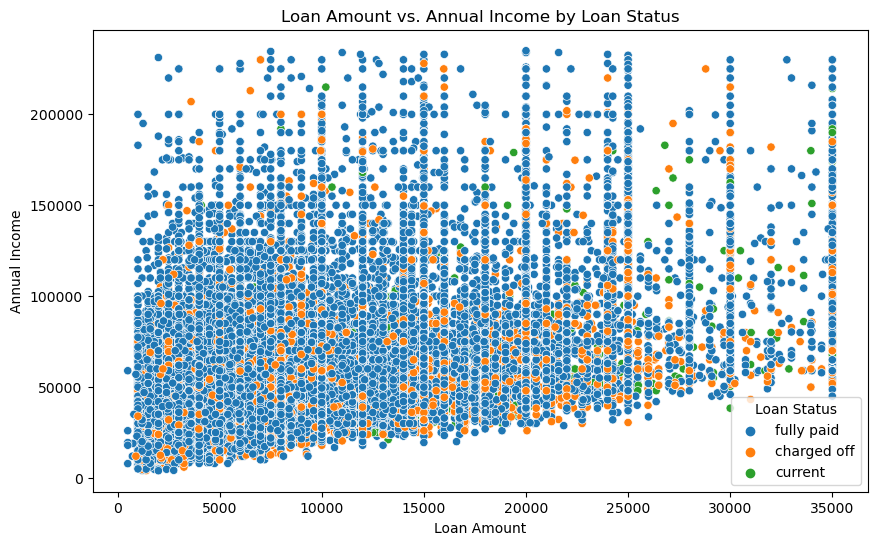

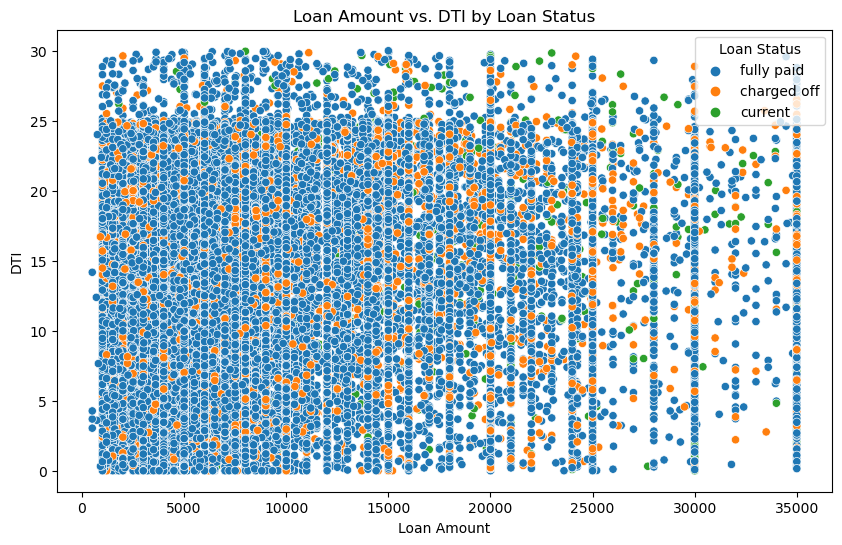

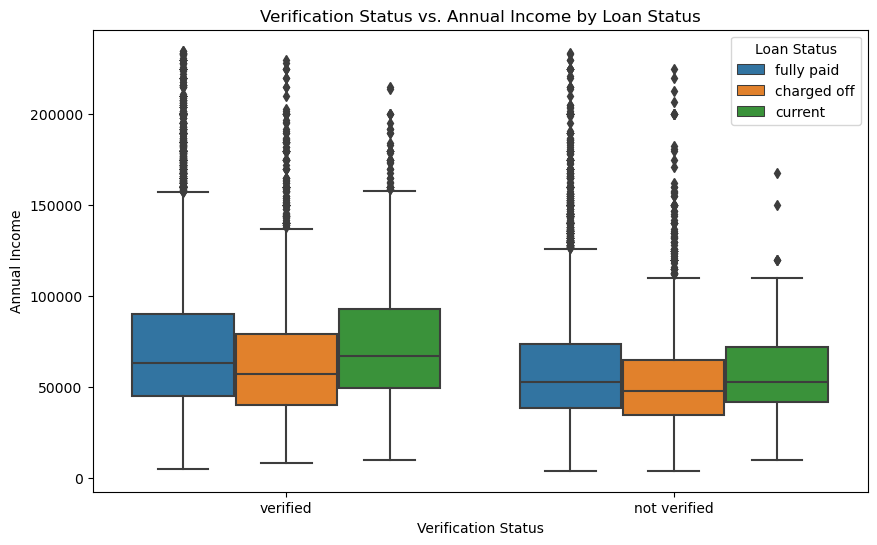

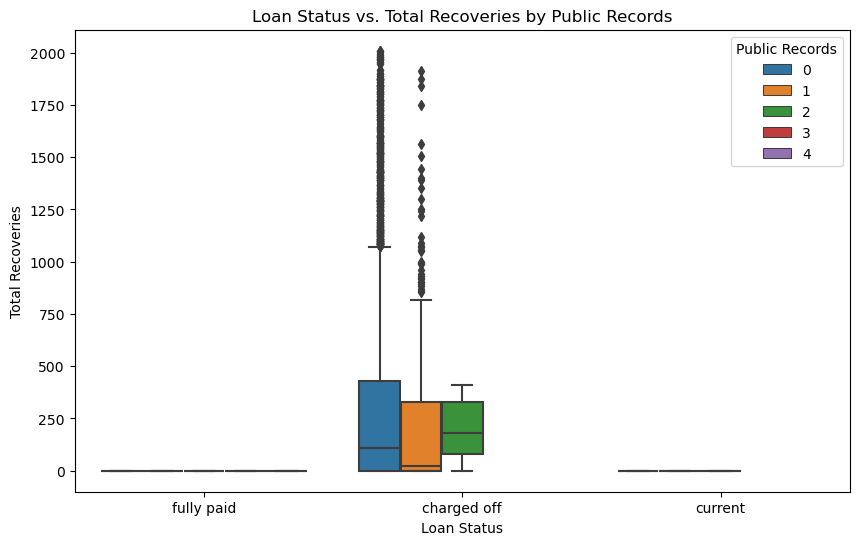

In [142]:

# Loan Amount, Annual Income, and Loan Status
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='loan_amnt', y='annual_inc', hue='loan_status')
plt.title('Loan Amount vs. Annual Income by Loan Status')
plt.xlabel('Loan Amount')
plt.ylabel('Annual Income')
plt.legend(title='Loan Status')
plt.show()

# Loan Amount, DTI, and Loan Status
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='loan_amnt', y='dti', hue='loan_status')
plt.title('Loan Amount vs. DTI by Loan Status')
plt.xlabel('Loan Amount')
plt.ylabel('DTI')
plt.legend(title='Loan Status')
plt.show()

# Annual Income, Verification Status, and Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='verification_status', y='annual_inc', hue='loan_status')
plt.title('Verification Status vs. Annual Income by Loan Status')
plt.xlabel('Verification Status')
plt.ylabel('Annual Income')
plt.legend(title='Loan Status')
plt.show()

# Total Recoveries, Loan Status, and Public Records
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='loan_status', y='recoveries', hue='pub_rec')
plt.title('Loan Status vs. Total Recoveries by Public Records')
plt.xlabel('Loan Status')
plt.ylabel('Total Recoveries')
plt.legend(title='Public Records')
plt.show()



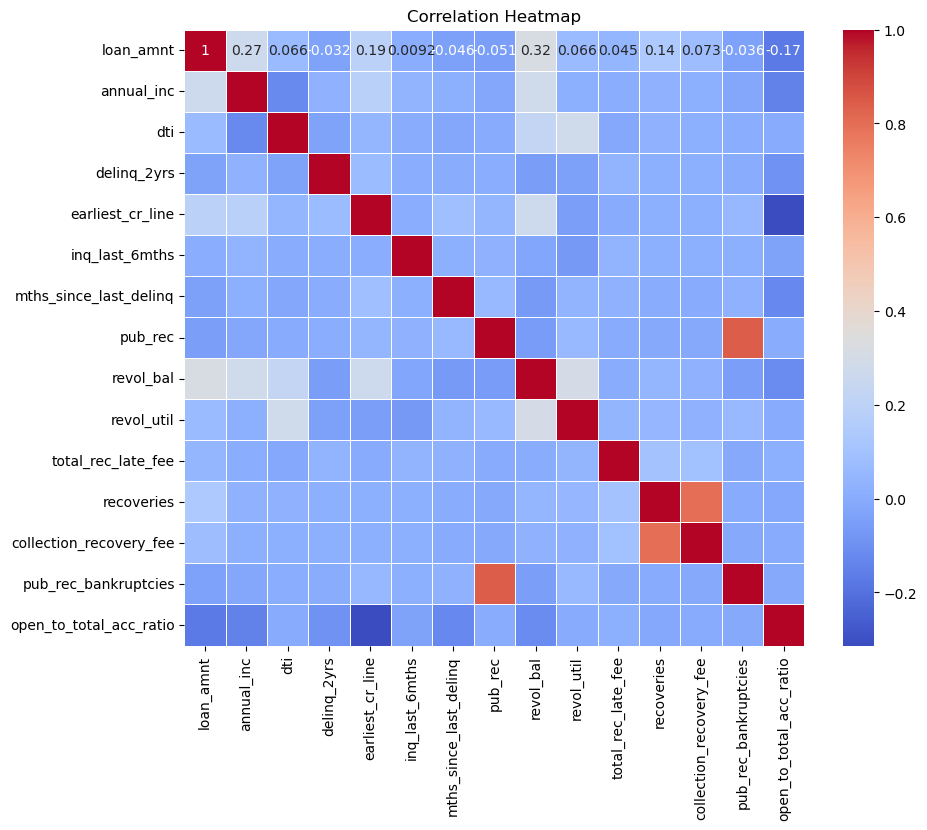

In [143]:
# Correlation Heatmap: Visualize the correlation between different variables.
# Calculate correlations for numeric columns
correlation_matrix = numeric_df.corr()
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Business Analysis
- Calculate normalized CBIL Score based on data available and mapped it against Loan Status
- Used CBIL score to understand Risk/Portfolio Assestment.
- Conclusion:
    - If CBIL Score is greater than of equal to 70, then Borrower is good candidate for Loan.
    - If CBIL Score is between 60 to 69, then Borrower is ok candidate for loan. We decrease the Loan Amount to mitigate risk.
    - If CBIL Score is below 60, then Borrower is risky candidate for loan. We can increase the Loan interest rate to mitigate risk.


In [144]:
# Define the columns for which you want to calculate factors
columns_to_process_repayment_history = ['delinq_2yrs', 'pub_rec', 'total_rec_late_fee', 'recoveries', 
                                        'collection_recovery_fee','last_pymnt_d', 'pub_rec_bankruptcies']
columns_to_process_credit_utilization = ['dti', 'revol_bal', 'revol_util', 'mths_since_last_delinq']
columns_to_process_credit_history_length = ['earliest_cr_line']
columns_to_process_credit_account_types = ['open_to_total_acc_ratio']
columns_to_process_recent_credit_inquiries = ['inq_last_6mths']

# calculate factors for each columns
factor = {'good' : 1, 'neutral' : 0.50, 'poor' : 0.25}

# Define weights for each factor (you can adjust these weights as needed)
weights = {
    'repayment_history': 0.35,
    'credit_utilization': 0.30,
    'credit_history_length': 0.15,
    'credit_account_types': 0.10,
    'recent_credit_inquiries': 0.10
}

In [145]:
# calculate factors for each columns
def calculate_factors(total_columns):
    return {
        'good': 100 / total_columns * factor['good'],
        'neutral': 100 / total_columns * factor['neutral'],
        'poor': 100 / total_columns * factor['poor']
    }

In [146]:
# Define a function to calculate the factor for a given column
# Use this function when your faovrable scenario is smaller number i.e. Good factor
def calculate_factor_value(value, good_range, neutral_range, factor_pts):
    if value is None or pd.isnull(value):
        return None  # Return None for missing values
    # Add your logic to calculate the factor based on the column's values
    if value <= good_range:
        return factor_pts['good']  # Good factor
    elif neutral_range[0] <= value <= neutral_range[1]:
        return factor_pts['neutral']  # Neutral factor
    else:
        return factor_pts['poor']  # Poor factor

In [147]:
# Define a function to calculate the factor for a given column
# Use this function when your faovrable scenario is greater number i.e. Good factor
def calculate_factor_value_rev(value, poor_range, neutral_range, factor_pts):
    if value is None or pd.isnull(value):
        return None  # Return None for missing values
    # Add your logic to calculate the factor based on the column's values
    if value <= poor_range:
        return factor_pts['poor']  # Poor factor
    elif neutral_range[0] <= value <= neutral_range[1]:
        return factor_pts['neutral']  # Neutral factor
    else:
        return factor_pts['good']  # Good factor

In [148]:
def divide_into_ranges(values):
    # Sort the unique values
    sorted_values = sorted(set(values))

    # Calculate breakpoints
    n = len(sorted_values)
    return {
        'breakpoint0': sorted_values[n // 3 - 1],
        'breakpoint1': sorted_values[n // 3],
        'breakpoint2': sorted_values[2 * (n // 3)]
    }

In [149]:
# Normalize values for each factor (you may need to adjust this based on your actual data)
repayment_history_factor = calculate_factors(len(columns_to_process_repayment_history))
credit_utilization_factor = calculate_factors(len(columns_to_process_credit_utilization))
credit_history_length_factor = calculate_factors(len(columns_to_process_credit_history_length))
credit_account_types_factor = calculate_factors(len(columns_to_process_credit_account_types))
recent_credit_inquiries_factor = calculate_factors(len(columns_to_process_recent_credit_inquiries))

# Calculate the factors for each row
repayment_history = pd.DataFrame()  # Calculate repayment history factor for the row
credit_utilization = pd.DataFrame()  # Calculate credit utilization factor for the row
credit_history_length = pd.DataFrame()  # Calculate credit history length factor for the row
credit_account_types = pd.DataFrame()  # Calculate credit account types factor for the row
recent_credit_inquiries = pd.DataFrame()  # Calculate recent credit inquiries factor for the row

In [150]:
# Calculate score for Repayment History

# Calculate range for respective column
total_rec_late_fee_range = divide_into_ranges(df['total_rec_late_fee'])
recoveries_range = divide_into_ranges(df['recoveries'])
collection_recovery_fee_range = divide_into_ranges(df['collection_recovery_fee'])
last_pymnt_d_range = divide_into_ranges(df['last_pymnt_d'])

# Define the columns and their respective ranges
repayment_history_column_ranges = {
    'delinq_2yrs': (2, (3, 6)),
    'pub_rec': (0, (1, 2)),
    'total_rec_late_fee': (total_rec_late_fee_range['breakpoint0'], (total_rec_late_fee_range['breakpoint1'], total_rec_late_fee_range['breakpoint2'])),
    'recoveries': (recoveries_range['breakpoint0'], (recoveries_range['breakpoint1'], recoveries_range['breakpoint2'])),           
    'collection_recovery_fee': (collection_recovery_fee_range['breakpoint0'], (collection_recovery_fee_range['breakpoint1'], collection_recovery_fee_range['breakpoint2'])),
    'last_pymnt_d': (last_pymnt_d_range['breakpoint0'], (last_pymnt_d_range['breakpoint1'], last_pymnt_d_range['breakpoint2'])),            
    'pub_rec_bankruptcies': (0, (1, 1))
}

# Iterate over each column and calculate the factor
for column in columns_to_process_repayment_history:
    # Extract the ranges for the current column
    good_range, neutral_range = repayment_history_column_ranges[column]
    # Create a new column in the repayment_history DataFrame with the calculated factors
    repayment_history[column] = df[column].apply(lambda x: calculate_factor_value(x, good_range, neutral_range, repayment_history_factor))


In [151]:
# Calculate score for Credit Utilization

annual_inc_range = divide_into_ranges(df['annual_inc'])
dti_range = divide_into_ranges(df['dti'])
mths_since_last_delinq_range = divide_into_ranges(df['mths_since_last_delinq'])
revol_bal_range = divide_into_ranges(df['revol_bal'])
revol_util_range = divide_into_ranges(df['revol_util'])

# Define the columns and their respective ranges
credit_utilization_column_ranges = {
    'dti': (dti_range['breakpoint0'], (dti_range['breakpoint1'], dti_range['breakpoint2'])),
    'revol_bal': (revol_bal_range['breakpoint0'], (revol_bal_range['breakpoint1'], revol_bal_range['breakpoint2'])),          
    'revol_util': (revol_util_range['breakpoint0'], (revol_util_range['breakpoint1'], revol_util_range['breakpoint2'])),
    'mths_since_last_delinq': (mths_since_last_delinq_range['breakpoint0'], (mths_since_last_delinq_range['breakpoint1'], mths_since_last_delinq_range['breakpoint2']))
}


# Iterate over each column and calculate the factor
for column in columns_to_process_credit_utilization:
    # Extract the ranges for the current column
    good_range, neutral_range = credit_utilization_column_ranges[column]
    # Create a new column in the repayment_history DataFrame with the calculated factors
    credit_utilization[column] = df[column].apply(lambda x: calculate_factor_value (x, good_range, neutral_range, credit_utilization_factor))
    # Create a new column in the credit_utilization DataFrame with the calculated factors
    if column in ['dti', 'revol_bal', 'revol_util']:
        credit_utilization[column] = df[column].apply(lambda x: calculate_factor_value(x, good_range, neutral_range, credit_utilization_factor))
    else:
        credit_utilization[column] = df[column].apply(lambda x: calculate_factor_value_rev(x, good_range, neutral_range, credit_utilization_factor))
        

In [152]:
# Calculate score for Credit History Length

earliest_cr_line_range = divide_into_ranges(df['earliest_cr_line'])


credit_history_length_column_ranges = {
    'earliest_cr_line': (earliest_cr_line_range['breakpoint0'], (earliest_cr_line_range['breakpoint1'], earliest_cr_line_range['breakpoint2']))
}

# earliest_cr_line:	The month the borrower's earliest reported credit line was opened
# Earlier the credit line better for CBIL
for column in columns_to_process_credit_history_length:
    # Extract the ranges for the current column
    poor_range, neutral_range = credit_history_length_column_ranges[column]
    # Create a new column in the credit_history_length DataFrame with the calculated factors
    credit_history_length[column] = df[column].apply(lambda x: calculate_factor_value_rev(x, poor_range, neutral_range, credit_history_length_factor))



In [153]:
# Calculate score for Credit Account Type

open_to_total_acc_ratio_range = divide_into_ranges(df['open_to_total_acc_ratio'])


credit_account_types_column_ranges = {
    'open_to_total_acc_ratio': (open_to_total_acc_ratio_range['breakpoint0'], (open_to_total_acc_ratio_range['breakpoint1'], open_to_total_acc_ratio_range['breakpoint2']))
}

# open_to_total_acc_ratio:	The month the borrower's earliest reported credit line was opened
# Earlier the credit line better for CBIL
for column in columns_to_process_credit_account_types:
    # Extract the ranges for the current column
    good_range, neutral_range = credit_account_types_column_ranges[column]
    # Create a new column in the credit_account_types DataFrame with the calculated factors
    credit_account_types[column] = df[column].apply(lambda x: calculate_factor_value(x, good_range, neutral_range, credit_account_types_factor))



In [154]:
# Calculate score for Recent Credit Inquiries

inq_last_6mths_range = divide_into_ranges(df['inq_last_6mths'])


recent_credit_inquiries_column_ranges = {
    'inq_last_6mths': (inq_last_6mths_range['breakpoint0'], (inq_last_6mths_range['breakpoint1'], inq_last_6mths_range['breakpoint2']))
}

# inq_last_6mths:	The month the borrower's earliest reported credit line was opened
# Earlier the credit line better for CBIL
for column in columns_to_process_recent_credit_inquiries:
    # Extract the ranges for the current column
    good_range, neutral_range = recent_credit_inquiries_column_ranges[column]
    # Create a new column in the recent_credit_inquiries DataFrame with the calculated factors
    recent_credit_inquiries[column] = df[column].apply(lambda x: calculate_factor_value(x, good_range, neutral_range, recent_credit_inquiries_factor))



In [155]:

# Create a new column with the sum of specified columns
repayment_history['total_sum'] = repayment_history[columns_to_process_repayment_history].sum(axis=1)
credit_utilization['total_sum'] = credit_utilization[columns_to_process_credit_utilization].sum(axis=1)
credit_history_length['total_sum'] = credit_history_length[columns_to_process_credit_history_length].sum(axis=1)
credit_account_types['total_sum'] = credit_account_types[columns_to_process_credit_account_types].sum(axis=1)
recent_credit_inquiries['total_sum'] = recent_credit_inquiries[columns_to_process_recent_credit_inquiries].sum(axis=1)

# Define the CBIL scoring algorithm
df['repayment_history'] = repayment_history['total_sum'] * weights['repayment_history']
df['credit_utilization'] = credit_utilization['total_sum'] * weights['credit_utilization']
df['credit_history_length'] = credit_history_length['total_sum'] * weights['credit_history_length']
df['credit_account_types'] = credit_account_types['total_sum'] * weights['credit_account_types']
df['recent_credit_inquiries'] = recent_credit_inquiries['total_sum'] * weights['recent_credit_inquiries']
df['CBIL_Score'] = df[['repayment_history', 'credit_utilization', 'credit_history_length', 'credit_account_types', 'recent_credit_inquiries']].sum(axis=1)


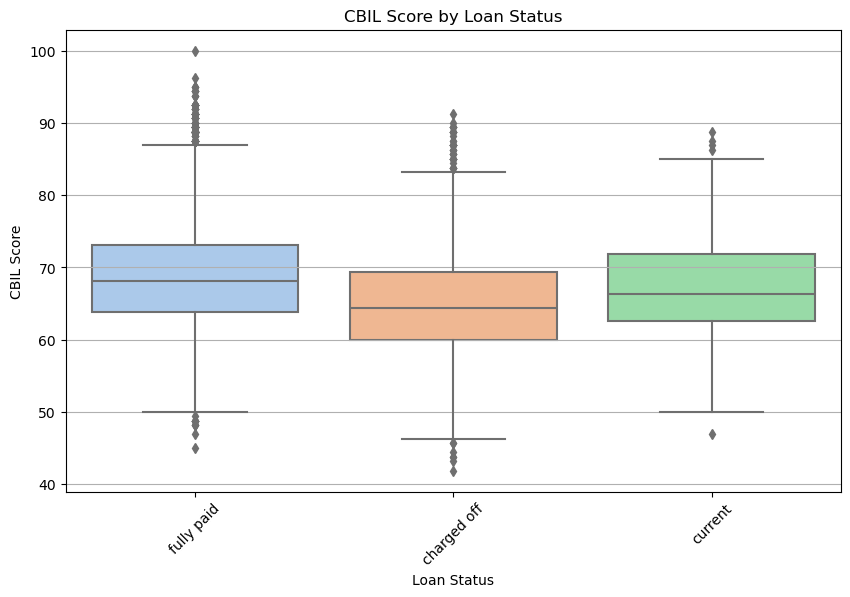

In [156]:
#Loan Status and CBIL Score Relationship: Analyze how loan status relates to CBIL scores and other factors.
# Box plot of CBIL Score by Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='CBIL_Score', data=df, palette='pastel')
plt.title('CBIL Score by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('CBIL Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()